## Correlation Coefficients
Instead of directly calculating RMSE as a predictive metric, look at the temporal evolution of the correlation between the perturbed and ctl runs. 

In [38]:
BASE_DIR_AM4 = "/scratch/users/robcking/am4_error_growth/"
BASE_DIR_MIMA = "/scratch/users/robcking/mima_predictability"

BASE_DIR = BASE_DIR_MIMA # N.B this is for Jan at the moment 
NAME = 'mima_jan'
FILE = 'mima_jan'

In [39]:
!module load ffmpeg
import re 
import os 
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt 

from glob import glob 
plt.rcParams['animation.ffmpeg_path'] ='/share/software/user/open/ffmpeg/5.0/bin/ffmpeg'


perturbed_memberlist = sorted(filter(lambda x: re.match(r'.+\/[0-9]+\/atmos_4xdaily.nc',x),glob(os.path.join(BASE_DIR,'*','atmos_4xdaily.nc'))),key=lambda x: int(re.search(r'\w+\/(\d+)\/\w+.nc',x).group(1)))
perturbed_precip_memberlist = sorted(filter(lambda x: re.match(r'.+\/[0-9]+\/atmos_4xdaily_precip.nc',x),glob(os.path.join(BASE_DIR,'*','atmos_4xdaily_precip.nc'))),key=lambda x: int(re.search(r'\w+\/(\d+)\/\w+.nc',x).group(1)))
perturbed_ds =  xr.open_mfdataset(perturbed_memberlist,combine='nested',concat_dim='members',chunks={'time':10,'pfull':'auto'},decode_times=False)
perturbed_precip_ds = xr.open_mfdataset(perturbed_precip_memberlist,combine='nested',concat_dim='members',chunks={'time':10,'pfull':'auto'},decode_times=False)


ctl_path = os.path.join(BASE_DIR,'ctl','atmos_4xdaily.nc')
ctl_precip_path = os.path.join(BASE_DIR,'ctl','atmos_4xdaily_precip.nc')
ctl_precip_ds = xr.open_dataset(ctl_precip_path,chunks={'time':10,'pfull':'auto'},decode_times=False)
ctl_ds = xr.open_dataset(ctl_path,chunks={'time':10,'pfull':'auto'},decode_times=False)



In [40]:
first_member = perturbed_ds.isel(members=0)
first_member

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 360, pfull: 40, lat: 64, lon: 128, phalf: 41, lonb: 129,
              latb: 65)
Coordinates:
  * lon      (lon) float32 512B 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lonb     (lonb) float32 516B -1.406 1.406 4.219 7.031 ... 353.0 355.8 358.6
  * lat      (lat) float32 256B -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * latb     (latb) float32 260B -90.0 -86.58 -83.76 -80.96 ... 83.76 86.58 90.0
  * pfull    (pfull) float32 160B 0.1782 0.5562 0.7238 ... 821.4 902.2 970.5
  * phalf    (phalf) float32 164B 0.0 0.4844 0.6312 0.8205 ... 863.5 941.4 1e+03
  * time     (time) float64 3kB 1.8e+03 1.8e+03 1.801e+03 ... 1.89e+03 1.89e+03
Data variables:
    ucomp    (time, pfull, lat, lon) float32 472MB dask.array<chunksize=(10, 40, 64, 128), meta=np.ndarray>
    vcomp    (time, pfull, lat, lon) float32 472MB dask.array<chunksize=(10, 40, 64, 128), meta=np.ndarray>
    temp     (time, pfull, lat, lon) float32 472MB dask.array<chunksize=(10, 40, 64, 128), meta=np.ndarray>
    olr      (time, lat, lon) float32 12MB dask.array<chunksize=(10, 64, 128), meta=np.ndarray>
    bk       (phalf) float32 164B dask.array<chunksize=(41,), meta=np.ndarray>
    pk       (phalf) float32 164B dask.array<chunksize=(41,), meta=np.ndarray>
    ps       (time, lat, lon) float32 12MB dask.array<chunksize=(10, 64, 128), meta=np.ndarray>
Attributes:
    filename:  atmos_4xdaily.nc
    title:     MiMA

### Pearson-R Correlation

Look at precip for starters?

In [41]:
from matplotlib.animation import FuncAnimation

def anim_scatter(ctl,estimator,var_name,estm_name='estimator'):
    fig,ax = plt.subplots()
    sct = ax.scatter(estimator.isel(time=0).values.ravel(),ctl.isel(time=0).values.ravel(),s=0.25)
    ax.plot([min(0,estimator.min()),estimator.max()*100],[min(0,estimator.min()),estimator.max()*100],'k--')
    plt.xlabel(f"{var_name} ({estm_name})")
    plt.ylabel(f"{var_name} (CTL)")
    plt.text(0.9,0.1,'overpredict',  verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,)
    plt.text(0.1,0.9,'underpredict', verticalalignment='bottom', horizontalalignment='left',
        transform=ax.transAxes,)
    ax.set_xlim([min(0,estimator.min()),estimator.max()*1.2])
    ax.set_ylim([min(0,estimator.min()),ctl.max()*1.2])
    def step(i):
        estim_var =estimator.isel(time=i).values.ravel()
        ctl_var = ctl.isel(time=i).values.ravel()
        sct.set_offsets(np.stack([estim_var,ctl_var],axis=-1))
        coeff = np.corrcoef(estim_var,ctl_var,rowvar=False)
    
        ax.set_title(f"{var_name}_ctl vs {var_name}_{estm_name} at t={i/4 + 0.25 }, Coeff={round(coeff[1,0],3)}")

        return sct,

    anim = FuncAnimation(fig,step,frames=len(ctl.time),blit=True,interval=100)
    return anim 
    

precip ctl vs i as fn of time for precip

In [42]:
def plot_predictive_measures(ctl,estimator,estimator_name='',var_name=''):
    rs = []
    r2s = []
    biases = []
    rmses = []
    for t in ctl.time:
        ctl_var = ctl.sel(time=t).values.ravel()
        estm_var = estimator.sel(time=t).values.ravel()
        bias = np.mean(estm_var - ctl_var)
        pearson_r = np.corrcoef(ctl_var,estm_var)[0,1]
        residual = np.sum((estm_var - ctl_var)**2)
        squares = np.sum((ctl_var- np.mean(ctl_var))**2)
        r2 = 1 - residual/squares
        rs.append(pearson_r)
        biases.append(bias)
        rmses.append(residual/len(ctl_var))
        r2s.append(r2)
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(6.5,13.8))

    fig.suptitle(f"{var_name} estimated using {estimator_name}")
    fig.tight_layout()
    ax1.plot(ctl.time-ctl.time[0],rs)
    ax1.set_xlabel("Days since init")
    ax1.set_ylabel("Pearson R Coeff")

    ax2.plot(ctl.time-ctl.time[0],r2s)
    ax2.set_xlabel("Days since init")
    ax2.set_ylabel("$R^2$")

    ax3.plot(ctl.time-ctl.time[0],rmses)
    ax3.set_xlabel("Days since init")
    ax3.set_ylabel("Avg Square Residual/ MSE")

    ax4.plot(ctl.time-ctl.time[0],biases)
    ax4.set_xlabel("Days since init")
    ax4.set_ylabel("Bias")

### Precip
#### Use single ensemble member

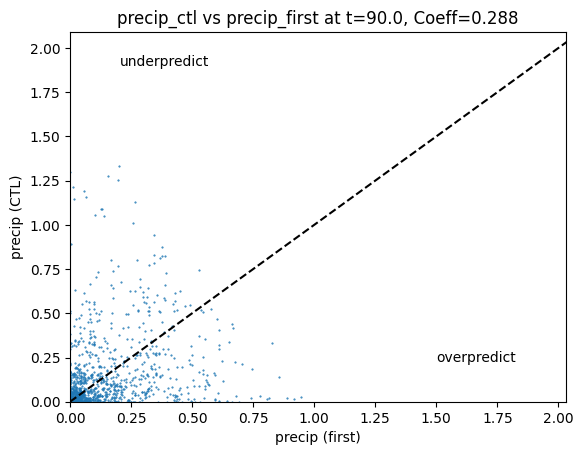

In [43]:
first_precip = perturbed_precip_ds.isel(members=0).precip.sel(lat=slice(-15,15))
ctl_precip = ctl_precip_ds.precip.sel(lat=slice(-15,15))

SECONDS_PER_6_HOUR = 60*60*6
RHO = 1000 # kg/m^3

first_precip = first_precip* (100*SECONDS_PER_6_HOUR/RHO) # cm / (6hrs)
ctl_precip = ctl_precip* (SECONDS_PER_6_HOUR*100/RHO)

anim = anim_scatter(ctl_precip,first_precip,estm_name='first',var_name='precip')
anim.save('precip_corr_1.gif')


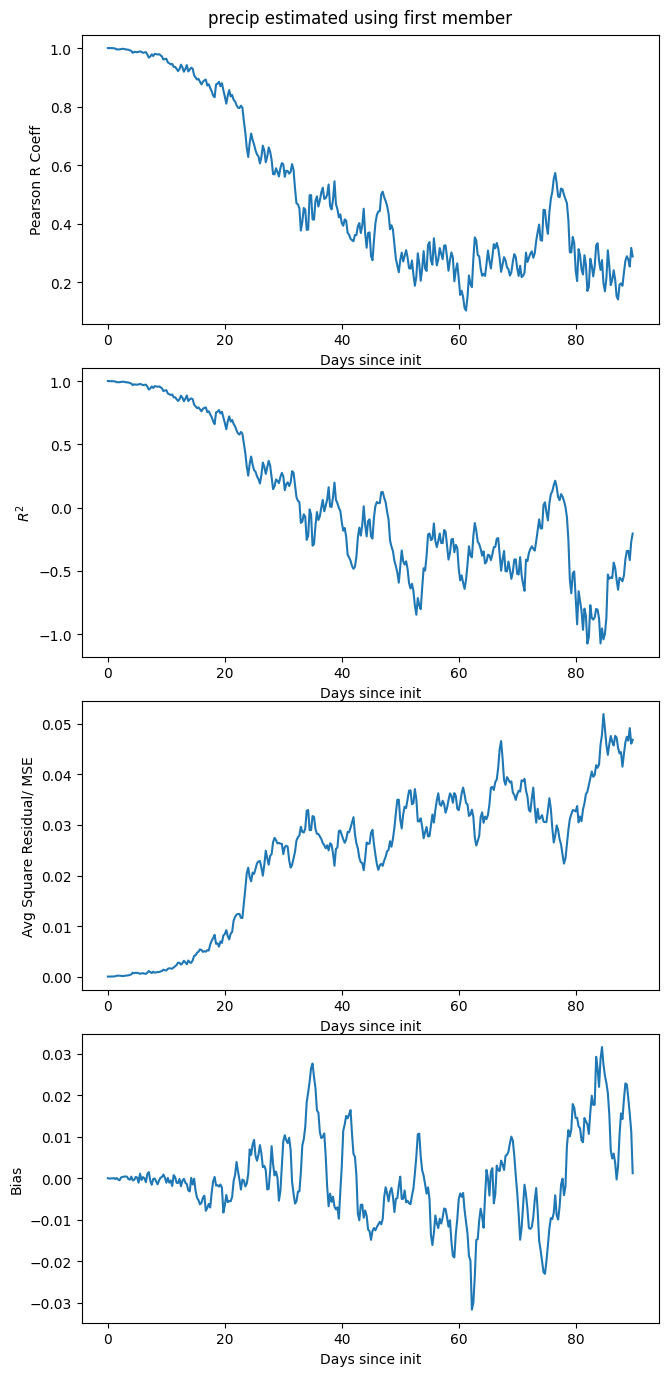

In [44]:
plot_predictive_measures(ctl_precip,first_precip,estimator_name='first member',var_name='precip')

#### Construct mean estimator

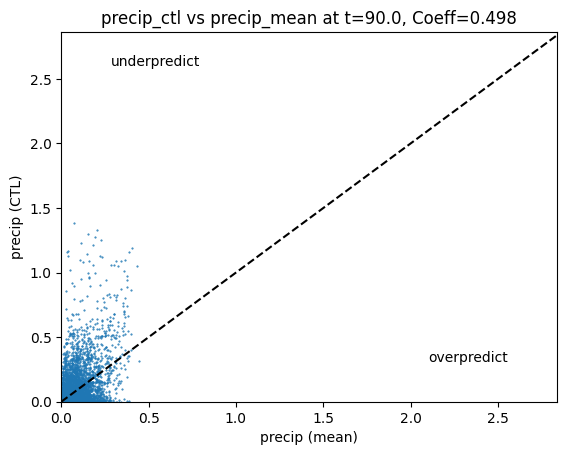

In [36]:
mean_precip = perturbed_precip_ds.precip.mean(dim='members')
mean_precip = mean_precip * (100*SECONDS_PER_6_HOUR/RHO)

anim = anim_scatter(ctl_precip,mean_precip,estm_name='mean',var_name='precip')
anim.save('precip_corr_mean.gif')


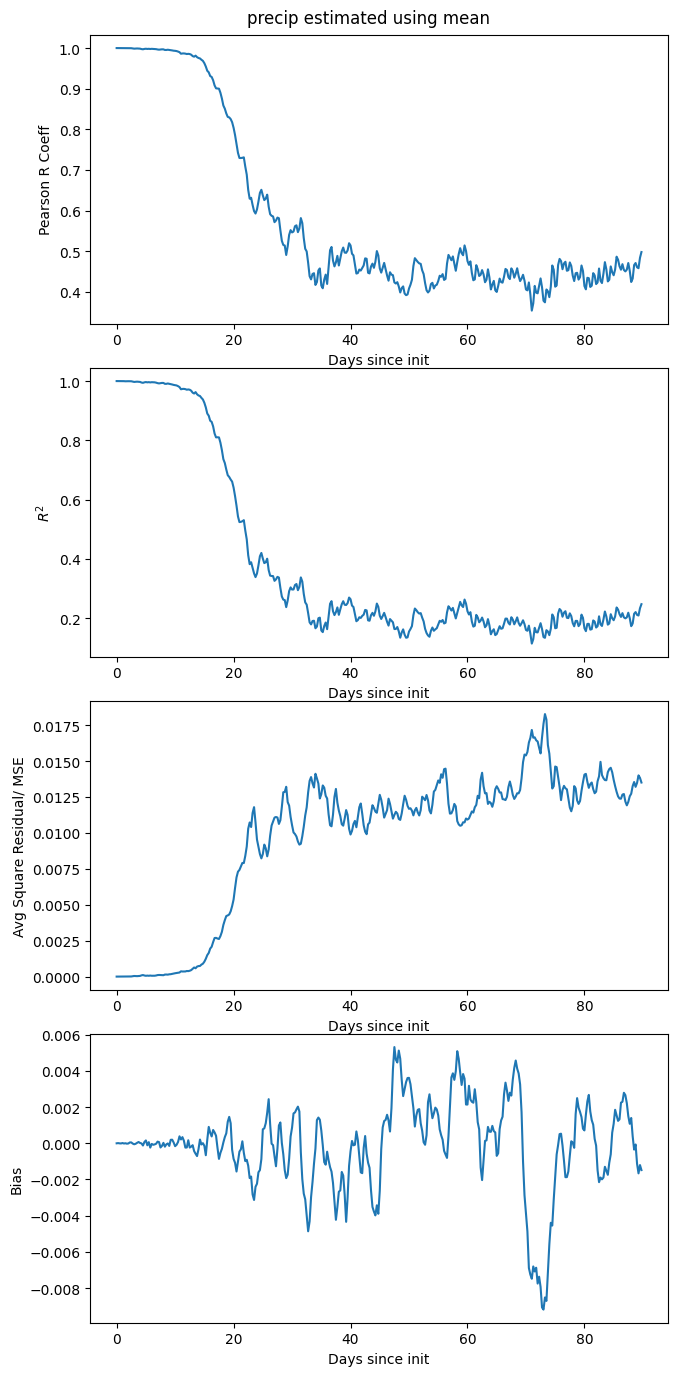

In [37]:
plot_predictive_measures(ctl_precip,mean_precip,var_name='precip',estimator_name='mean')

### cumulative precip


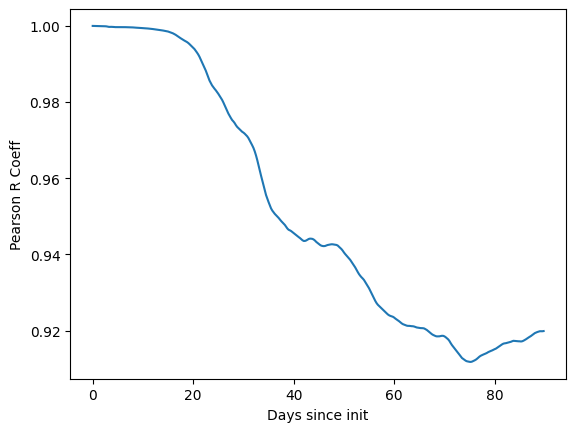

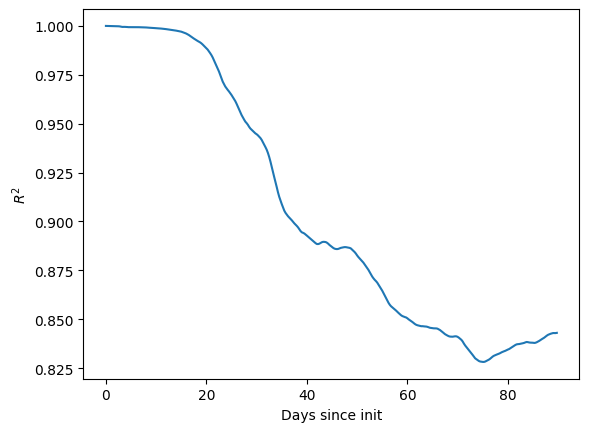

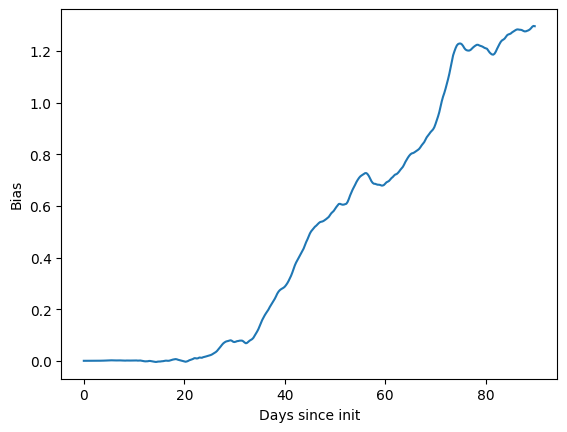

In [59]:
ctl_cum_precip = ctl_precip.cumulative("time").sum()
first_cum_precip = first_precip.cumulative("time").sum()
plot_predictive_measures(ctl_cum_precip,first_cum_precip)


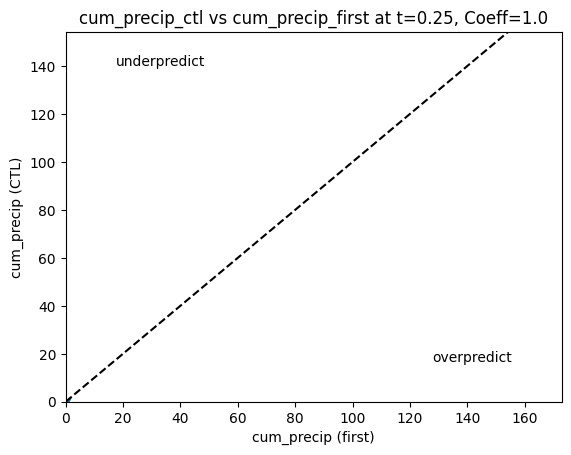

In [60]:
anim = anim_scatter(ctl_cum_precip,first_cum_precip,estm_name='first',var_name='cum_precip')

In [61]:
anim.save('cum_precip_1.gif')

### predictive in location



In [15]:
COORDS_PA = (37.4419, 122.1430) ## PALO ALTO, CA Coordinates (LATLON)
COORDS_LON = (51.5072, 0.1276) ## LONDON, UK Coordinates
COORDS_SING = (1.3521, 103.8198) ## SINGAPORE COORDINATES

precip_pa_ctl = ctl.precip.sel(lat=COORDS_PA[0],lon=COORDS_PA[1],method='nearest')
precip_pa_mem = perturbed_ds.precip.sel(lat=COORDS_PA[0],lon=COORDS_PA[1],method='nearest')



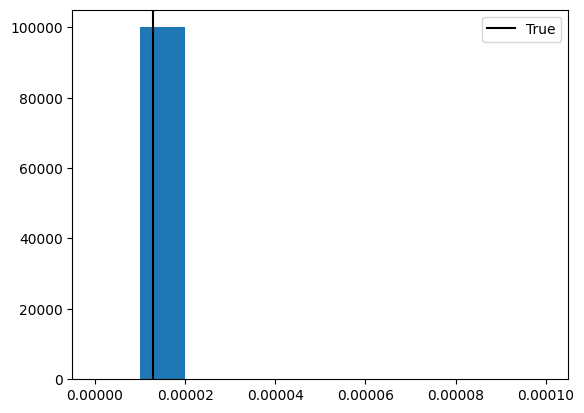

In [65]:
def make_anim(ds_ctl,ds_mem):
    fig, ax = plt.subplots()
    target = ds_ctl.isel(time=0)
    spread_0 = ds_mem.isel(time=0)
    ns, _  = np.histogram(spread_0,bins=10,range=(0,0.0001))
    _,_,bar_container = ax.hist(spread_0,bins=10,range=(0,0.0001),density=True)
    ln = ax.axvline(target,c='black',label='True')
    ax.legend()

    def step(i):
        target = ds_ctl.isel(time=i).values
        spread = ds_mem.isel(time=i).values
        ln.set_xdata([target])
        ns, _  = np.histogram(spread,bins=10,range=(0,0.0001),density=True)
        for (count,bars) in zip(ns,bar_container.patches):
             bars.set_height(count)
        return (*bar_container.patches, ln)

    anim = FuncAnimation(fig,step,frames=len(ds_ctl.time),blit=True)
    return anim 


pa_anim = make_anim(precip_pa_ctl,precip_pa_mem)


## Predicting "surface" winds vs Stratospheric winds


In [16]:
surf=1000 #hPa
strat = 50 #hPa 

surf_wind = ctl_ds.ucomp.sel(pfull=surf,method='nearest')
strato_wind = ctl_ds.ucomp.sel(pfull=strat,method='nearest')

NameError: name 'ctl_ds' is not defined